In [2]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. LIBRERÍAS Y RUTAS
# ────────────────────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, joblib, yfinance as yf, pathlib, sys, warnings
from scipy.stats import skew, kurtosis
warnings.simplefilter("ignore", FutureWarning)

ROOT = pathlib.Path().resolve().parent      # …/notebooks → raíz del proyecto
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import config as cfg                      #  rutas DATA, RESULT, etc.

# ────────────────────────────────────────────────────────────────────────────────
# 1. MODELOS A COMPARAR  (alias : fichero)
# ────────────────────────────────────────────────────────────────────────────────
MODELS = {
    "LSTM-1d" : cfg.RESULT / "backtest_lstm.pkl",
    "LSTM-5d" : cfg.RESULT / "backtest_lstm5d.pkl",
    "GRU-5d"  : cfg.RESULT / "backtest_gru5d.pkl",
    "XGB-fact": cfg.RESULT / "backtest_xgb.pkl",
    "CNN-5d"  : cfg.RESULT / "backtest_cnn5d.pkl"  # ← NUEVO
}

BENCH_TICKERS = ["SPY", "BIL"]
START_DATE    = "2019-01-02"
END_DATE      = pd.Timestamp.today().normalize()

# ────────────────────────────────────────────────────────────────────────────────
# 2. CALENDARIO DIARIO MAESTRO  (S&P 500)
# ────────────────────────────────────────────────────────────────────────────────
spx = yf.download("^GSPC", start=START_DATE, end=END_DATE,
                  progress=False, auto_adjust=False)
prices_spx = spx["Adj Close"] if "Adj Close" in spx.columns else spx["Close"]
calendar   = prices_spx.dropna().index                     # fechas hábiles globales

# ────────────────────────────────────────────────────────────────────────────────
# 3. CARGAR RETORNOS DE CADA MODELO  (relleno 0 %)
# ────────────────────────────────────────────────────────────────────────────────
ret_models: dict[str, pd.Series] = {}
for alias, fpath in MODELS.items():
    if not fpath.exists():
        raise FileNotFoundError(f"[{alias}] no se encuentra {fpath}")
    bt          = joblib.load(fpath)
    serie_ret   = bt["retorno"].reindex(calendar).fillna(0.0)
    if serie_ret.abs().sum() == 0:
        raise ValueError(f"[{alias}] vector de retornos vacío — revisa el back-test")
    ret_models[alias] = serie_ret

# ────────────────────────────────────────────────────────────────────────────────
# 4. BENCHMARKS SPY Y BIL  (alineados al mismo calendario)
# ────────────────────────────────────────────────────────────────────────────────
raw = yf.download(BENCH_TICKERS, start=START_DATE, end=END_DATE,
                  progress=False, auto_adjust=False)
prices_bench = (raw["Adj Close"]
                if "Adj Close" in raw.columns.get_level_values(0)
                else raw["Close"]).ffill()

ret_bench = np.log(prices_bench / prices_bench.shift(1)).reindex(calendar).fillna(0)
ret_spy   = ret_bench["SPY"]
ret_cash  = ret_bench["BIL"]

# ────────────────────────────────────────────────────────────────────────────────
# 5. FUNCIÓN DE MÉTRICAS
# ────────────────────────────────────────────────────────────────────────────────
def _stats(r: pd.Series) -> dict[str, float]:
    ann = np.sqrt(252)
    wealth = (1 + r).cumprod()
    return {
        "Rentabilidad (%)" : (wealth.iloc[-1] - 1) * 100,
        "Volatilidad (%)"  : r.std(ddof=1) * ann * 100,
        "Sharpe"           : r.mean() / r.std(ddof=1) * ann,
        "MaxDD (%)"        : (wealth.cummax() - wealth).max() * 100,
        "Asimetría"        : skew(r),
        "Curtosis"         : kurtosis(r),
    }

# ────────────────────────────────────────────────────────────────────────────────
# 6. TABLA COMPARATIVA
# ────────────────────────────────────────────────────────────────────────────────
metrics = {alias: _stats(r) for alias, r in ret_models.items()}
metrics["SPY"] = _stats(ret_spy)
metrics["BIL"] = _stats(ret_cash)

tabla = pd.DataFrame(metrics).T.round(2)

print("\n── Comparativa de modelos (2019-hoy, calendario diario común) ──\n")
display(tabla)   # en .py puedes usar: print(tabla.to_markdown())



── Comparativa de modelos (2019-hoy, calendario diario común) ──



,Rentabilidad (%),Volatilidad (%),Sharpe,MaxDD (%),Asimetría,Curtosis
LSTM-1d,70.47,14.71,0.63,34.62,-1.66,51.71
LSTM-5d,250.49,16.35,1.26,30.68,15.86,417.44
GRU-5d,179.13,18.27,0.95,31.98,22.50,752.08
XGB-fact,54.55,14.37,0.54,26.57,-2.30,42.65
CNN-5d,143.24,11.16,1.29,37.05,1.07,57.05
SPY,138.52,20.36,0.76,48.90,-0.57,13.58
BIL,16.93,0.25,9.54,0.21,0.85,1.27


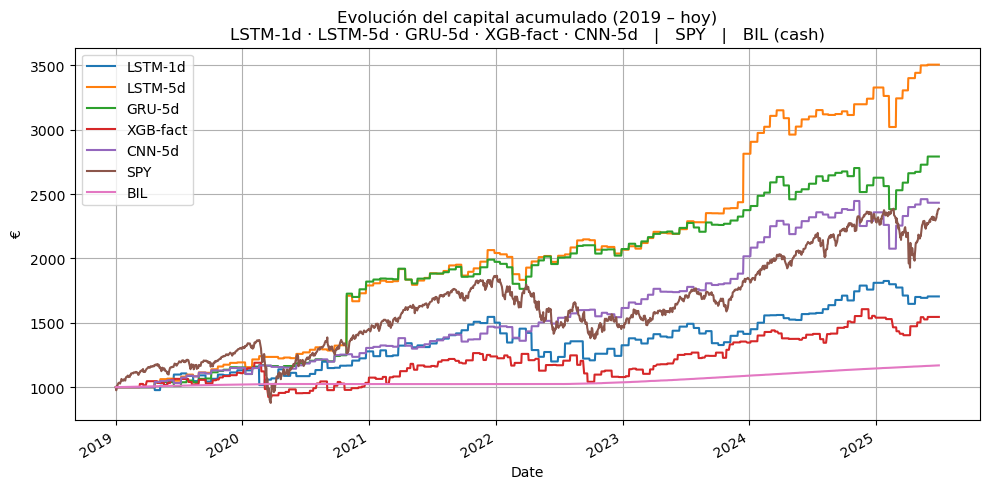

In [4]:
# ────────────────────────────────────────────────────────────────────────────────
# 7. GRÁFICO DE CAPITAL ACUMULADO: modelos vs benchmarks
# ────────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt, matplotlib.dates as mdates

CAPITAL0 = 1_000  # € iniciales para todos

# — 7.1  Curvas de riqueza acumulada —
wealth = {
    alias: (1 + r).cumprod() * CAPITAL0
    for alias, r in ret_models.items()
}
wealth["SPY"] = (1 + ret_spy ).cumprod() * CAPITAL0
wealth["BIL"] = (1 + ret_cash).cumprod() * CAPITAL0

# — 7.2  Plot —
fig, ax = plt.subplots(figsize=(10, 5))

for name, serie in wealth.items():
    serie.plot(ax=ax, label=name)

ax.set_ylabel("€")
model_names = " · ".join(ret_models.keys())
ax.set_title(f"Evolución del capital acumulado (2019 – hoy)\n"
             f"{model_names}   |   SPY   |   BIL (cash)")
ax.grid(True)
ax.legend(loc="upper left")

# eje temporal con marcas anuales limpias
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()
